In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils_io import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* Mask of recognised items
* List of recognised items

In [3]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [19]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [28]:
bin_stamp = '170508103814'
contents = ["mouse_traps","composition_book","tennis_ball_container",
            "tissue_box"]

In [29]:
contents = [s.lower() for s in contents]

['tennis_ball_container']

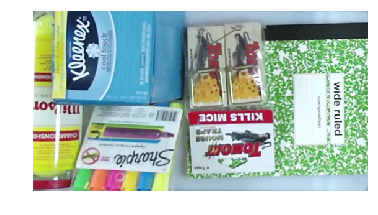

In [30]:
from utils_io import imread_rgb, imread_gray, read_json

image_bin = imread_rgb('bin/' + bin_stamp + '.png')
image_mask = imread_gray('bin/' + bin_stamp + '_item_mask.pgm')
plt.imshow(image_bin); plt.axis('off');
data = read_json('bin/' + bin_stamp + '_items.json')
recognised_items = [name for name, proj in data]
items = [item for item in contents if not item in recognised_items]
items

In [31]:
from utils_color import find_items_by_color

In [32]:
recognised_items, bboxes = find_items_by_color(image_bin, image_mask, items)

In [33]:
recognised_items

['tennis_ball_container']

In [34]:
bboxes

[(1, 155, 97, 133)]

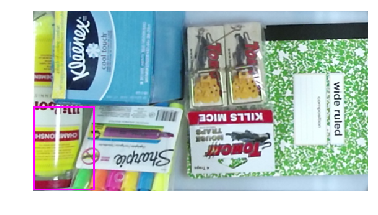

In [35]:
image_disp = image_bin.copy()
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0),
          'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0),
          'tennis_ball_container':(255,0,255)}

for item, bb in zip(recognised_items, bboxes):
    if not bb is None:
        x,y,w,h = bb
        cv2.rectangle(image_disp, (x,y), (x+w,y+h), it_col[item],2)
plt.imshow(image_disp); plt.axis('off');

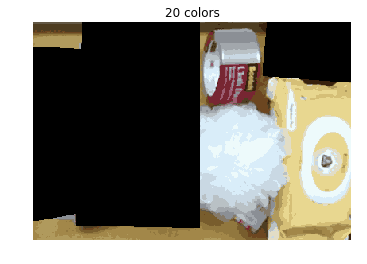

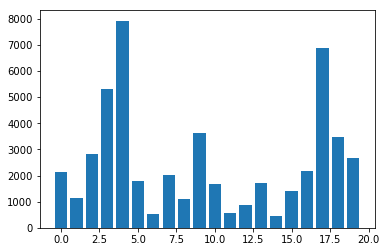

In [6]:
from utils_color import cluster_colors

positions, weights = cluster_colors(image_bin, image_mask, items, n_cc=20, debug=True)

In [7]:
weights

[[(0.21008874657293897, 'burts_bees_baby_wipes')],
 [(0.20341434757271723, 'bath_sponge'),
  (0.11671916465620942, 'burts_bees_baby_wipes')],
 [(0.23397445701208086, 'duct_tape'),
  (0.50876317150967709, 'bath_sponge'),
  (0.28568352069390185, 'burts_bees_baby_wipes')],
 [],
 [],
 [],
 []]

In [8]:
pos_ok = [(p,w[0][1]) for p,w in zip(positions, weights) if len(w)==1]
pos_unkw = [(p,w) for p,w in zip(positions, weights) if len(w)>1]

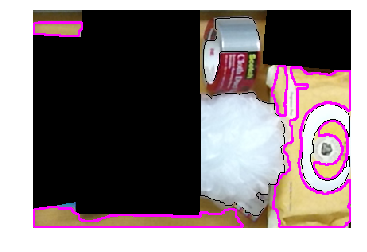

In [9]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0),
          'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0),
          'tennis_ball_container':(255,0,255)}
#image_disp = image_bin.copy()
image_disp = cv2.bitwise_and(image_bin, image_bin, mask=image_mask)

#mask_disp  = 255 - image_mask
contours = {}
for item in items:
    contours[item] = []
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        contours[item] += cnt
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); plt.axis('off');

In [10]:
from utils_contour import contourClustering

clusters = {}
threshold = 30
for item in items:
    clusters[item] = contourClustering(contours[item], threshold)

In [11]:
clusters

{'bath_sponge': [],
 'burts_bees_baby_wipes': [[0, 4, 2], [1], [3]],
 'duct_tape': []}

In [12]:
recognised_items += [ item for item in clusters.keys() if clusters[item] ]
recognised_items

[u'colgate_toothbrush_4pk',
 u'epsom_salts',
 u'crayons',
 'burts_bees_baby_wipes']

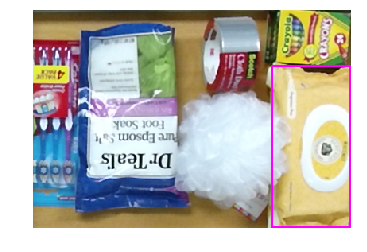

In [13]:
image_disp = image_bin.copy()
#image_disp = cv2.bitwise_and(image_bin, image_bin, mask=image_mask)

for item in items:
    area = 0
    for cl in clusters[item]:
        cc = [c for idx, c in enumerate(contours[item]) if idx in cl]
        # TODO: oriented rectangle
        x,y,w,h = cv2.boundingRect(np.vstack(tuple(cc)))
        if area < w*h:
            area = w*h
            bb = (x,y,w,h)
    if area > 0:
        x,y,w,h = bb
        cv2.rectangle(image_disp, (x,y), (x+w,y+h), it_col[item],2)
        cv2.rectangle(image_mask, (x,y), (x+w,y+h), 0, -1)
plt.imshow(image_disp); plt.axis('off');

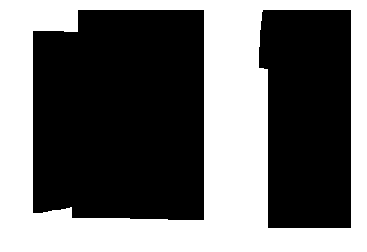

In [14]:
kernel = np.ones((3,3),np.uint8)
image_mask = cv2.erode(image_mask, kernel, iterations = 5)
plt.imshow(image_mask,cmap='gray'); plt.axis('off');

In [15]:
items = [item for item in contents if not item in recognised_items]
items

['duct_tape', 'bath_sponge']

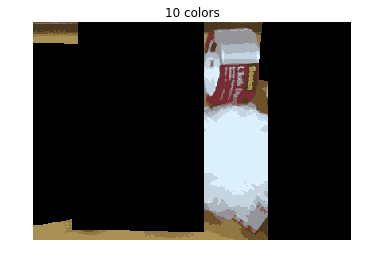

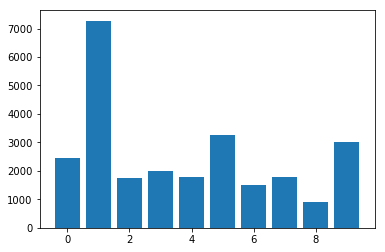

In [16]:
positions, weights = cluster_colors(image_bin, image_mask, items, n_cc=10)

In [17]:
weights

[[(0.11271662714064705, 'duct_tape'), (0.3000460176386866, 'bath_sponge')],
 [],
 [],
 [],
 [(0.1955855874500714, 'duct_tape')]]

In [18]:
pos_ok = [(p,w[0][1]) for p,w in zip(positions, weights) if len(w)==1]
pos_unkw = [(p,w) for p,w in zip(positions, weights) if len(w)>1]

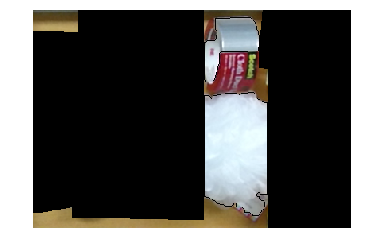

In [19]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0),
          'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0)}
#image_disp = image_bin.copy()
image_disp = cv2.bitwise_and(image_bin, image_bin, mask=image_mask)

#mask_disp  = 255 - image_mask
contours = {}
for item in items:
    contours[item] = []
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        contours[item] += cnt
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); plt.axis('off');

In [20]:
clusters = {}
threshold = 30
for item in items:
    clusters[item] = contourClustering(contours[item], threshold)

In [21]:
clusters

{'bath_sponge': [], 'duct_tape': []}

In [22]:
recognised_items += [ item for item in clusters.keys() if clusters[item] ]
recognised_items

[u'colgate_toothbrush_4pk',
 u'epsom_salts',
 u'crayons',
 'burts_bees_baby_wipes']

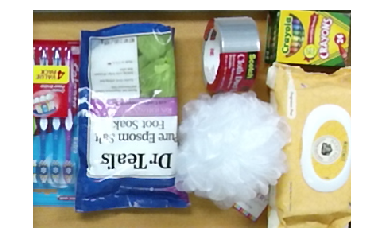

In [23]:
image_disp = image_bin.copy()
for item in items:
    area = 0
    for cl in clusters[item]:
        cc = [c for idx, c in enumerate(contours[item]) if idx in cl]
        # TODO: oriented rectangle
        x,y,w,h = cv2.boundingRect(np.vstack(tuple(cc)))
        #cv2.rectangle(image_disp, (x,y), (x+w,y+h), it_col[item],2)
        if area < w*h:
            area = w*h
            bb = (x,y,w,h)
    if area > 0:
        x,y,w,h = bb
        cv2.rectangle(image_disp, (x,y), (x+w,y+h), it_col[item],2)
        cv2.rectangle(image_mask, (x,y), (x+w,y+h), 0, -1)
plt.imshow(image_disp); plt.axis('off');